<h1><center>plant disease detector</center><h1>
<img src="https://images.unsplash.com/photo-1564543236611-216a24136f51?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=750&q=80" style="width : 750px ; height : 410px " >

In [1]:
!pip install -U -q PyDrive
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-10-09 10:59:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.200.233.201, 52.207.111.186, 3.213.5.196, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.200.233.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  37.6MB/s    in 0.3s    

2019-10-09 10:59:20 (37.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:

#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#import zipfile
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot  as plt  
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input
from tensorflow.keras.callbacks import *
from tensorflow.keras import metrics

from PIL import Image
#import os
import numpy as np
import json
import sys
import getopt
from time import time

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import pandas as pd

#from google.colab import drive
#from google.colab import files
from PIL import Image
import utils

%matplotlib inline

In [7]:
PATH='/content/gdrive'
LOG_DIR = 'log/'
with open('idx_to_class.json', 'r') as fp:
    data = json.load(fp)
    idx_to_class= {int(k):class_name  for k,class_name in data.items() }

In [2]:
get_ipython().system_raw(
    'tensorboard --logdir={} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
            

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
def build_model(num_classes,input_shape=(224,224,3)):
  """
  Args:
            num_classes (int): number of classes
            intut_shape (tuple): shape of image as an input , default value if not specified : (244,224,3)
  """
  
  input_tensor = Input(shape=input_shape)
  base_model = VGG16(include_top=False,weights="imagenet",input_tensor=input_tensor)
  x = base_model.output
  x = Flatten()(x)
  # let's add 2 fully-connected layers with 1024 units
  x = Dense(1024, activation='relu')(x)
  x = Dense(1024, activation='relu')(x)
  # and a logistic layer -- let's say we have 200 classes
  predictions = Dense(num_classes, activation='softmax')(x)
  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False
  return model    


In [5]:
def load_model(best_checkpoint_path="/content/gdrive/My Drive/checkpoints/epochs:009-val_acc:0.953.hdf5"):    
    model = build_model(len(idx_to_class)) 
    model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights(best_checkpoint_path)

In [6]:
utils.my_auth()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# create dataset generators

In [9]:
#upload the dataset 
utils.upload_data()

init_setting= dict(rescale=1./255,
             #  preprocessing_function=preprocess_input,
               zca_whitening=True,
               horizontal_flip=True,
               vertical_flip=True,
               validation_split=0.25)
setting=dict(target_size=(224,224),
             color_mode='rgb',
             batch_size=32,
             class_mode='categorical',
             shuffle=True)


train_datagen=ImageDataGenerator(**init_setting)
test_datagen=ImageDataGenerator(rescale=1./255)
delete_ugly()
train_generator=train_datagen.flow_from_directory('./dataset_itr2/train', 
                                                   subset='training',**setting)
valid_generator=train_datagen.flow_from_directory('./dataset_itr2/train', 
                                                  subset='validation',**setting)

#since it's a test set , we need to preserve the images order and omit shuffeling 
setting["shuffle"]=False

test_generator=test_datagen.flow_from_directory(directory='./dataset_itr2/test',
                                                  **setting)



Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
kaggle.json
100% 3.20G/3.20G [00:52<00:00, 84.6MB/s]
100% 3.20G/3.20G [00:52<00:00, 65.0MB/s]
finished !


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


0 ugly files deleted from test
Found 130356 images belonging to 38 classes.
Found 43452 images belonging to 38 classes.
Found 41614 images belonging to 38 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


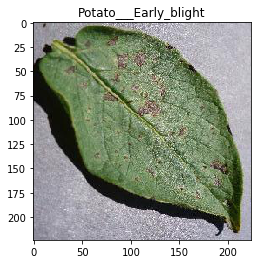

In [12]:
(images,labels)=train_generator.next()
plt.imshow(images[0,:])
plt.title(idx_to_class[np.argmax(labels[0,:]) ])
plt.show()

# train the model

In [10]:
model=build_model(len(idx_to_class))  
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 1

In [10]:

#---------------------compile model---------------------------------------------------
model.compile(optimizer="Adam",loss='categorical_crossentropy', metrics=["accuracy"])
steps_per_epochs=train_generator.n//train_generator.batch_size
valid_steps=valid_generator.n//valid_generator.batch_size


#---------------------prepare callbacks----------------------------------------

filepath="/content/gdrive/My Drive/checkpoints/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"    

tbCallBack = TensorBoard(log_dir='log/'.format(time()), histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=train_generator.batch_size,
                         write_images=True)
                        
es_callback=EarlyStopping(patience=5,verbose=1,min_delta=1e-3)
rop_callback=ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.01,verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

#---------------------train model -----------------------------------------------
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=steps_per_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_steps,
                    epochs=20,
                    verbose=1,
                    callbacks=[tbCallBack,checkpoint,es_callback,rop_callback])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
http://613869b9.ngrok.io


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:7

1357/4073 [========>.....................] - ETA: 16:29 - loss: 0.3300 - acc: 0.8925
Epoch 00001: val_loss improved from inf to 0.32997, saving model to /content/gdrive/My Drive/checkpoints/epochs:001-val_acc:0.893.hdf5
4073/4073 [==============================] - 2041s 501ms/step - loss: 0.4600 - acc: 0.8548 - val_loss: 0.3300 - val_acc: 0.8925
Epoch 2/20
1357/4073 [========>.....................] - ETA: 16:27 - loss: 0.2919 - acc: 0.9082
Epoch 00002: val_loss improved from 0.32997 to 0.29193, saving model to /content/gdrive/My Drive/checkpoints/epochs:002-val_acc:0.908.hdf5
4073/4073 [==============================] - 2030s 498ms/step - loss: 0.2396 - acc: 0.9206 - val_loss: 0.2919 - val_acc: 0.9082
Epoch 3/20
1357/4073 [========>.....................] - ETA: 16:29 - loss: 0.2424 - acc: 0.9216
Epoch 00003: val_loss improved from 0.29193 to 0.24243, saving model to /content/gdrive/My Drive/checkpoints/epochs:003-val_acc:0.922.hdf5
4073/4073 [==============================] - 2028s 498

# Evaluation

## 1.model accuracy & loss plots

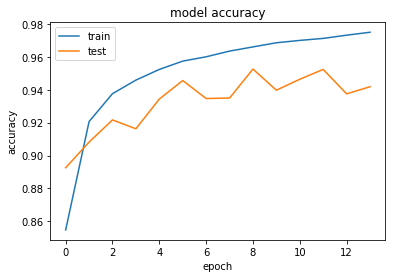

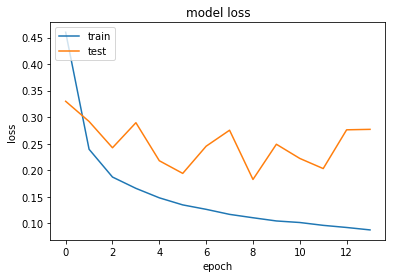

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2.classification report 

In [20]:
#let's first load the best checkpoint
load_model("/content/gdrive/My Drive/checkpoints/epochs:009-val_acc:0.953.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step


In [29]:
steps=test_generator.n//test_generator.batch_size+1
y_test=test_generator.classes
y_pred=model.predict_generator(test_generator,steps=steps,verbose=1)
y_pred=np.argmax(y_pred,axis=1)
target_names=list(idx_to_class.values())

print("test accuracy : {} %".format(round(accuracy_score(y_test,y_pred),4 )*100) )

confusion_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),columns = target_names , index=target_names) 
confusion_mat

test accuracy : 95.12 %


,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Blueberry___healthy,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour)___healthy,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Common_rust_,Corn_(maize)___Northern_Leaf_Blight,Corn_(maize)___healthy,Grape___Black_rot,Grape___Esca_(Black_Measles),Grape___Leaf_blight_(Isariopsis_Leaf_Spot),Grape___healthy,Orange___Haunglongbing_(Citrus_greening),Peach___Bacterial_spot,Peach___healthy,"Pepper,_bell___Bacterial_spot","Pepper,_bell___healthy",Potato___Early_blight,Potato___Late_blight,Potato___healthy,Raspberry___healthy,Soybean___healthy,Squash___Powdery_mildew,Strawberry___Leaf_scorch,Strawberry___healthy,Tomato___Bacterial_spot,Tomato___Early_blight,Tomato___Late_blight,Tomato___Leaf_Mold,Tomato___Septoria_leaf_spot,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_mosaic_virus,Tomato___healthy
Apple___Apple_scab,456,0,0,26,0,2,0,1,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,0,4,0,0,0,0,4,4,0,0,0,0,0,0
Apple___Black_rot,10,476,0,3,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
Apple___Cedar_apple_rust,4,1,200,2,0,4,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,0,0
Apple___healthy,18,4,0,1244,0,4,0,0,0,0,0,0,0,0,1,0,4,6,0,0,0,0,0,0,16,0,0,0,14,1,3,0,0,0,1,0,0,0
Blueberry___healthy,1,0,0,0,1196,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Cherry_(including_sour)___Powdery_mildew,1,0,0,0,0,833,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0
Cherry_(including_sour)___healthy,0,0,0,2,0,0,658,0,0,0,0,0,0,0,0,5,2,1,0,1,0,0,0,1,5,0,4,0,0,0,0,0,1,0,0,0,0,0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0,0,0,0,0,0,0,324,1,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
Corn_(maize)___Common_rust_,0,0,0,0,0,0,0,0,950,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Corn_(maize)___Northern_Leaf_Blight,0,0,0,0,0,0,0,31,0,753,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
print(classification_report(y_test, y_pred, target_names=target_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.90      0.91       504
                                 Apple___Black_rot       0.99      0.96      0.97       496
                          Apple___Cedar_apple_rust       1.00      0.91      0.95       220
                                   Apple___healthy       0.97      0.95      0.96      1316
                               Blueberry___healthy       0.98      1.00      0.99      1200
          Cherry_(including_sour)___Powdery_mildew       0.97      0.99      0.98       840
                 Cherry_(including_sour)___healthy       1.00      0.97      0.98       680
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.79      0.85       408
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       952
               Corn_(maize)___Northern_Leaf_Blight       0.88      0.96      0.

## 3.plot predictions

In [0]:
def prediction(model,img_path,topk):
  img = image.load_img(img_path, target_size=(224, 224))
  input_image = image.img_to_array(img)
  input_image = np.expand_dims(input_image, axis=0)
  input_image/=255
  preds = model.predict(input_image)
 
  idx=preds.argsort().squeeze(0).tolist()[-topk:][::-1]
  top_pred=preds.squeeze(0)[idx]
  classes=[idx_to_class[x] for x in idx]
  plot_prob(input_image,top_pred,classes,topk)
  print('Predicted: {} \nclass {} '.format(top_pred,classes))
  

In [0]:
def plot_prob(img,ps,classes,topk):
  fig,(ax1,ax2)=plt.subplots(figsize=(11,20),ncols=2)
  ax1.axis('off')
  img=(img*255).astype(np.uint8)
  ax1.imshow(img.squeeze())
  ax1.set_title('leaf')
  ax2.barh(np.arange(topk),ps,align='center',alpha=.5)
  ax2.set(yticks=range(topk),yticklabels=classes )
  ax2.set_aspect(0.1)
  ax2.set_xlim(0, 1.1)
  plt.tight_layout()
  

Predicted: [9.9935287e-01 6.2550453e-04 1.5370711e-05 6.2295358e-06 2.0956929e-08] 
class ['Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___healthy', 'Corn_(maize)___Common_rust_', 'Strawberry___Leaf_scorch'] 


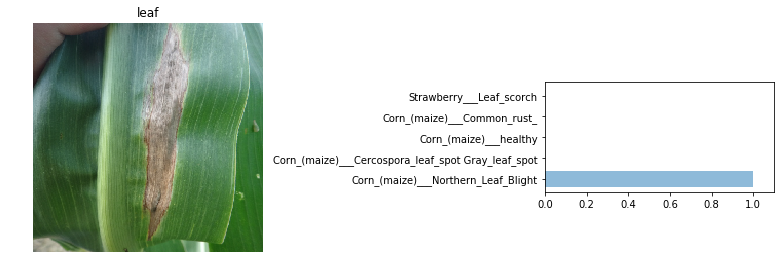

In [28]:
prediction(model,'./test4.png',5)